# **Preliminary Data Analysis**

This script performs exploratory data analysis (EDA) on the whole dataset and predominantly on the sample of Amazon fashion item reviews (available [here](https://T34278926.quickconnect.to/d/s/zpVAefWwFEYfIhTRTc0RfJ1h4rXzh6kJ/7VRz2eFaGxxjR11Xtygq65lAszhLPaIi-7LuAL9qlnQs) and [here](https://github.com/TomSOWI/DLSS-24-Synthetic-Product-Reviews-Generation/blob/main/Data/preprocessed_reviews.parquet)):

Whole dataset:
* Rating distribution (overall and by sentiment)

Training sample:
* Rating distribution (overall and by sentiment)
* Review length (average length and standard deviation of length) 
* Word clouds (for all reviews, by sentiment, and by rating)
* Topic modeling using BERTopic

## Preparations

In [1]:
# Import necessary packages
import re
from zipfile import ZipFile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from datasets import load_dataset
from langdetect import detect, DetectorFactory
from transformers import set_seed
from collections import Counter
import nltk
from wordcloud import WordCloud
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import os

# Download additional files for NLTK
nltk.download('punkt')
nltk.download('stopwords')

# Set seed for reproducible and consistent results
set_seed(42)

[nltk_data] Downloading package punkt to C:\Users\Valentin
[nltk_data]     Velev\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Valentin
[nltk_data]     Velev\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load the preprocessed data

In [2]:
# Load the larger dataset (2M)
reviews_all = pd.read_parquet('Data/checkpoint2.parquet')

# Load the smaller dataset (100k)
reviews_sample = pd.read_parquet('Data/preprocessed_reviews.parquet')

# Whole dataset

### Ratings

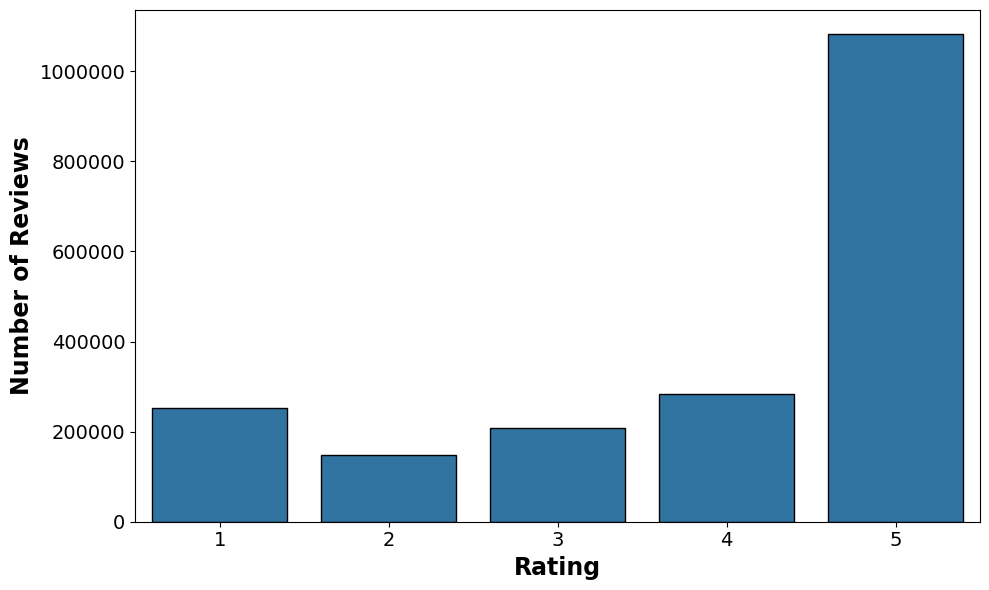

In [3]:
# Extract number of reviews by ratings
ratings = pd.DataFrame(reviews_all['rating'].value_counts())

# Plot number of reviews by ratings
plt.figure(figsize=(10, 6))
sns_barplot = sns.barplot(x='rating', y='count', data=ratings)
for bar in sns_barplot.patches:
    bar.set_edgecolor('black')  # Set the border color
    bar.set_linewidth(1)        # Set the border thickness
plt.xlabel('Rating', weight='bold', fontsize=18)
plt.ylabel('Number of Reviews', weight='bold', fontsize=18)
plt.xticks([0, 1, 2, 3, 4], labels=[1, 2, 3, 4, 5], fontsize=15)
plt.yticks(fontsize=15)
# Disable scientific notation for y axis
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()

### Sentiment distribution by rating

In [4]:
# Number and percentage of positive reviews in cleaned dataset
category_number = reviews_all['label'].value_counts()
print('Number of positive reviews: ' + str(category_number[1]))

category_percentages = reviews_all['label'].value_counts(normalize=True) * 100
print('Percentage of positive reviews: ' + str(category_percentages[1]))

Number of positive reviews: 1403637
Percentage of positive reviews: 71.14122498959722


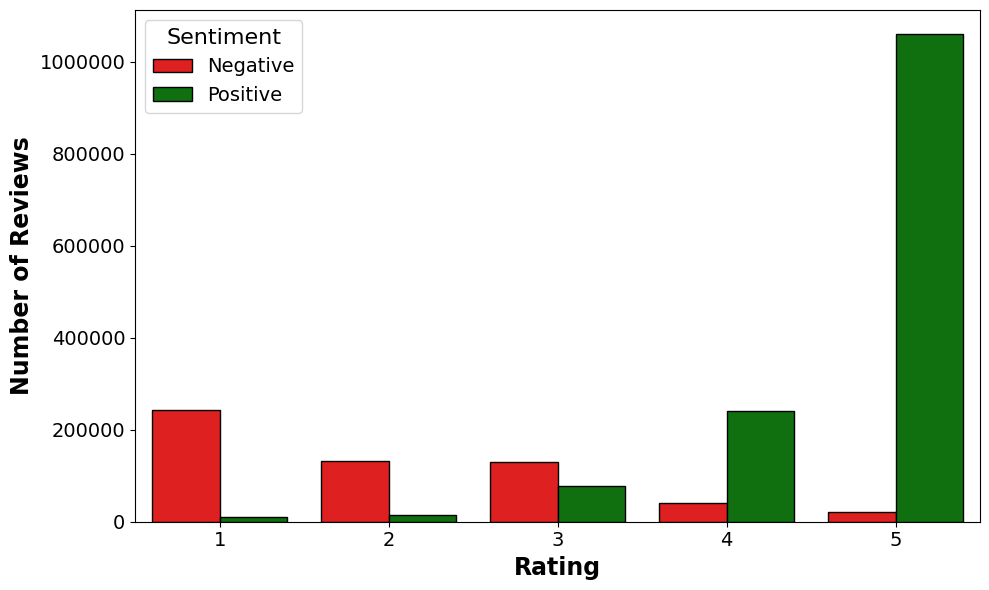

In [5]:
# Extract number of reviews by ratings and sentiment
value_counts = reviews_all.groupby(['rating', 'label']).size().reset_index(name='counts')

# Plot number of reviews by ratings and senitment
plt.figure(figsize=(10, 6))
sns_barplot = sns.barplot(data=value_counts, x='rating', y='counts', hue='label', palette={0: 'red', 1: 'green'})
for bar in sns_barplot.patches:
    bar.set_edgecolor('black')  # Set the border color
    bar.set_linewidth(1)        # Set the border thickness
plt.xlabel('Rating', weight='bold', fontsize=18)
plt.ylabel('Number of Reviews', weight='bold', fontsize=18)
plt.xticks([0, 1, 2, 3, 4], labels=[1, 2, 3, 4, 5], fontsize=15)
plt.yticks(fontsize=15)
# Disable scientific notation for y axis
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.ticklabel_format(style='plain', axis='y')
handles, labels = plt.gca().get_legend_handles_labels()
custom_labels = ['Negative', 'Positive']
plt.legend(title='Sentiment', handles=handles, labels=custom_labels, title_fontsize=16, fontsize=14)
plt.tight_layout()
plt.show()

# Training Data

## Review length

### Distribution of Review Lengths

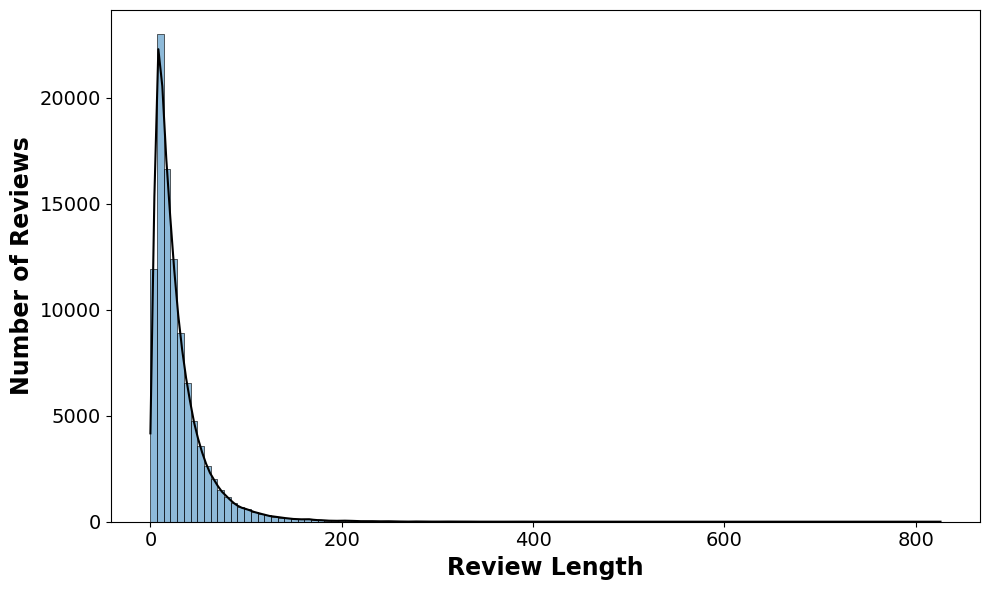

In [6]:
# Tokenize the reviews and determine their lengths
revs = reviews_sample['text'].copy()

doc_lengths = []

for rev in revs:
    tokens = nltk.word_tokenize(rev)
    tokens = [word.lower() for word in tokens if word.isalpha()]
    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

# Plot the distribution of review lengths (Figure A1 in the Appendix)
plt.figure(figsize=(10, 6))
ax = sns.histplot(doc_lengths, binwidth=7, kde=True)
ax.lines[0].set_color('black')
plt.xlabel('Review Length', weight='bold', fontsize=18)
plt.ylabel('Number of Reviews', weight='bold', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# Disable scientific notation for y axis
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.ticklabel_format(style='plain', axis='y')
os.makedirs('Plots', exist_ok=True) # Create folder named "Plots", in case there is no
plt.savefig('Plots/hist_rev_len.pdf', format='pdf', dpi=1500)
plt.tight_layout()
plt.show()

### Review Lengths (Total and by Sentiment)

In [7]:
# Calculations for text in Data chapter 
print('Average length of all reviews: ' + str(np.average(doc_lengths)))
print('Standard deviation of the length of all reviews: ' + str(np.std(doc_lengths)))

# Calculations for footnote in Data chapter
## Length of positive reviews
revs_pos = reviews_sample[reviews_sample['label'] == 1]['text'].copy()

doc_lengths_pos = []

for rev in revs_pos:
    tokens = nltk.word_tokenize(rev)
    tokens = [word.lower() for word in tokens if word.isalpha()]
    doc_lengths_pos.append(len(tokens))

doc_lengths_pos = np.array(doc_lengths_pos)

## Length of negative reviews
revs_neg = reviews_sample[reviews_sample['label'] == 0]['text'].copy()

doc_lengths_neg = []

for rev in revs_neg:
    tokens = nltk.word_tokenize(rev)
    tokens = [word.lower() for word in tokens if word.isalpha()]
    doc_lengths_neg.append(len(tokens))

doc_lengths_neg = np.array(doc_lengths_neg)

## Check average length and SD of length
print('\n')
print('Average length of positive reviews: ' + str(np.average(doc_lengths_pos)))
print('Standard deviation of the length of positive reviews: ' + str(np.std(doc_lengths_pos)))

print('\n')
print('Average length of negative reviews: ' + str(np.average(doc_lengths_neg)))
print('Standard deviation of the length of negative reviews: ' + str(np.std(doc_lengths_neg)))

Average length of all reviews: 28.9132
Standard deviation of the length of all reviews: 30.848347861109193


Average length of positive reviews: 27.21905
Standard deviation of the length of positive reviews: 30.872316354583763


Average length of negative reviews: 30.042633333333335
Standard deviation of the length of negative reviews: 30.780599123455815


## Rating Distribution

### Overall Rating Distribution

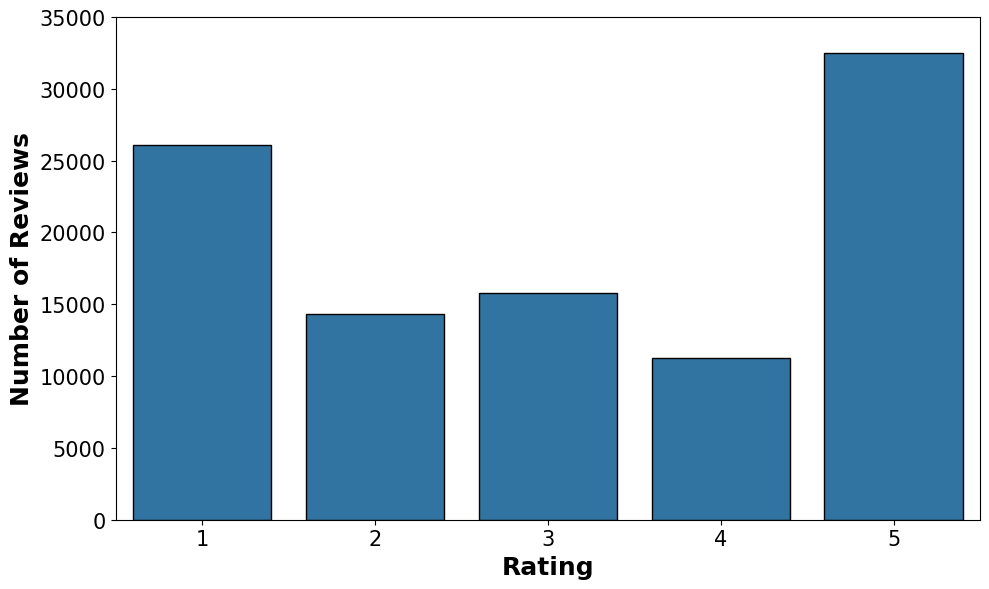

In [8]:
# Extract number of reviews by ratings
ratings = pd.DataFrame(reviews_sample['rating'].value_counts())

# Plot number of reviews by ratings
plt.figure(figsize=(10, 6))
sns_barplot = sns.barplot(x='rating', y='count', data=ratings)
for bar in sns_barplot.patches:
    bar.set_edgecolor('black')  # Set the border color
    bar.set_linewidth(1)        # Set the border thickness
plt.xlabel('Rating', weight='bold', fontsize=18)
plt.ylabel('Number of Reviews', weight='bold', fontsize=18)
plt.xticks([0, 1, 2, 3, 4], labels=[1, 2, 3, 4, 5], fontsize=15)
plt.yticks(fontsize=15)
# Disable scientific notation for y axis
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.ticklabel_format(style='plain', axis='y')
plt.ylim(top=35000)
plt.savefig('Plots/rating_distribution.pdf', format='pdf', dpi=1500)
plt.tight_layout()
plt.show()

### Rating Distribution by Sentiment

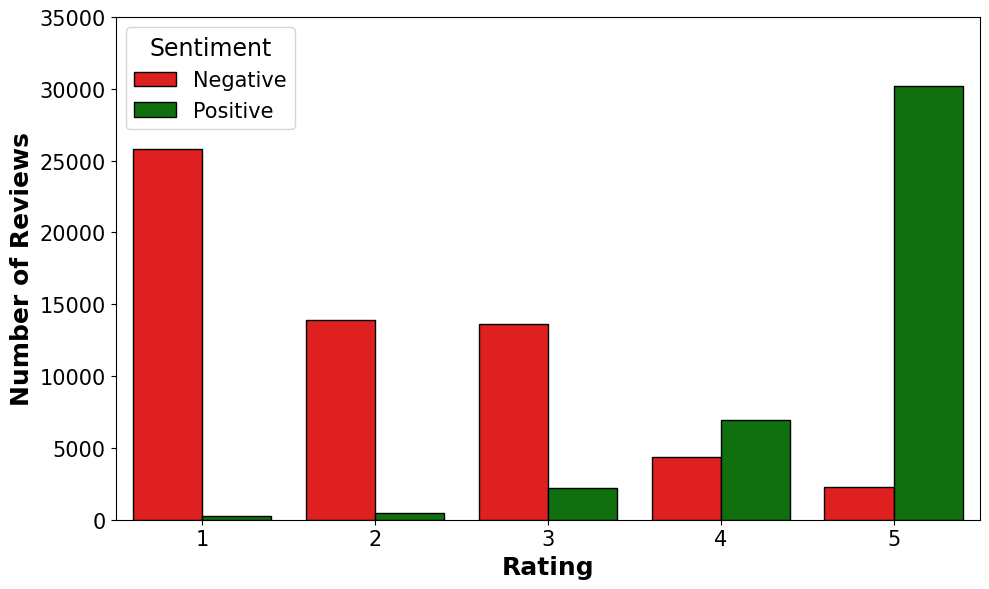

In [9]:
# Extract number of reviews by ratings and sentiment
value_counts = reviews_sample.groupby(['rating', 'label']).size().reset_index(name='counts')

# Plot number of reviews by ratings and senitment
plt.figure(figsize=(10, 6))
sns_barplot = sns.barplot(data=value_counts, x='rating', y='counts', hue='label', palette={0: 'red', 1: 'green'})
for bar in sns_barplot.patches:
    bar.set_edgecolor('black')  # Set the border color
    bar.set_linewidth(1)        # Set the border thickness
plt.xlabel('Rating', weight='bold', fontsize=18)
plt.ylabel('Number of Reviews', weight='bold', fontsize=18)
plt.xticks([0, 1, 2, 3, 4], labels=[1, 2, 3, 4, 5], fontsize=15)
plt.yticks(fontsize=15)
# Disable scientific notation for y axis
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.ticklabel_format(style='plain', axis='y')
plt.ylim(top=35000)
handles, labels = plt.gca().get_legend_handles_labels()
custom_labels = ['Negative', 'Positive']
plt.legend(title='Sentiment', handles=handles, labels=custom_labels, title_fontsize=17, fontsize=15)
plt.savefig('Plots/rating_distribution_sentiment.pdf',format='pdf', dpi=1500)
plt.tight_layout()
plt.show()

## Word Clouds

### TF-IDF

In [10]:
# Extract the reviews
revs = reviews_sample['text'].copy()

# Create the vectorizer
vectorizer = TfidfVectorizer(stop_words='english', lowercase=True)

# Fit and transform the reviews
tfidf_matrix = vectorizer.fit_transform(revs)

# Get the feature names (the terms)
feature_names = vectorizer.get_feature_names_out()

# Convert the matrix to an array for easier viewing
tfidf_array = tfidf_matrix.toarray()

### Word Cloud for all Reviews

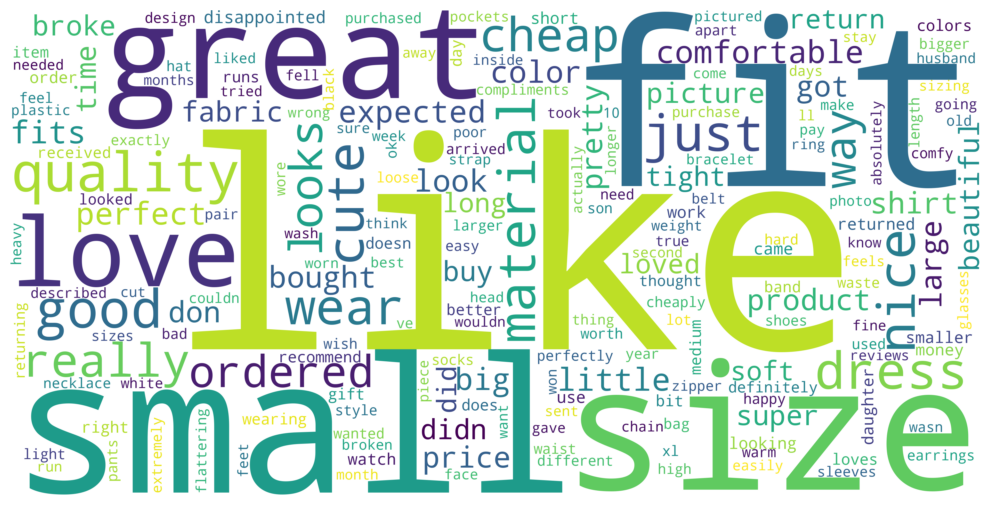

In [11]:
# Sum the TF-IDF scores for each term across all documents
tfidf_scores = tfidf_matrix.sum(axis=0).A1  # .A1 flattens the matrix into an array

# Create a dictionary of words and their corresponding TF-IDF scores
tfidf_dict = dict(zip(feature_names, tfidf_scores))

# Generate the word cloud
wordcloud = WordCloud(width=4000, height=2000, background_color='white', colormap='viridis').generate_from_frequencies(tfidf_dict)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout()
plt.savefig('Plots/wordcloud.pdf', format='pdf', dpi=1000)
plt.show()

### Word Clouds by Sentiment

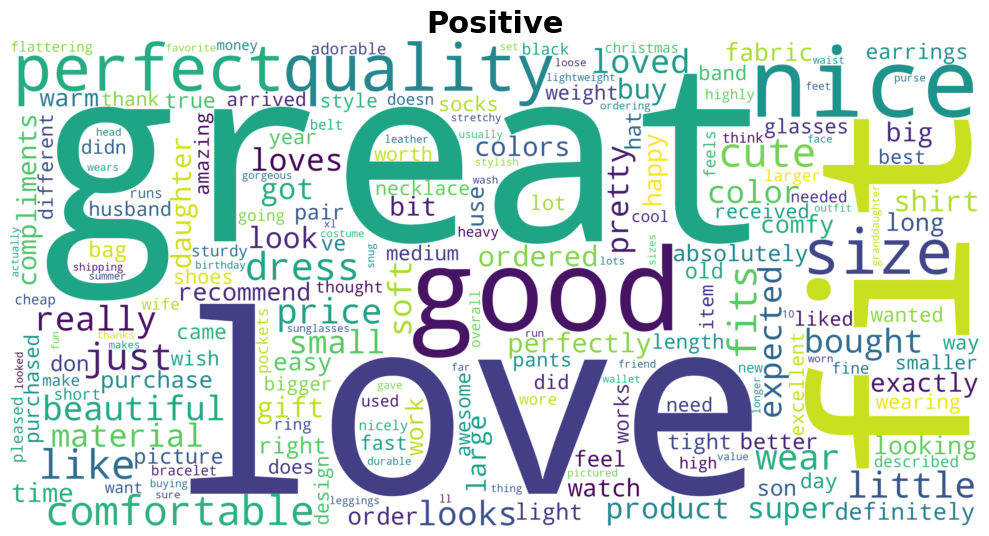

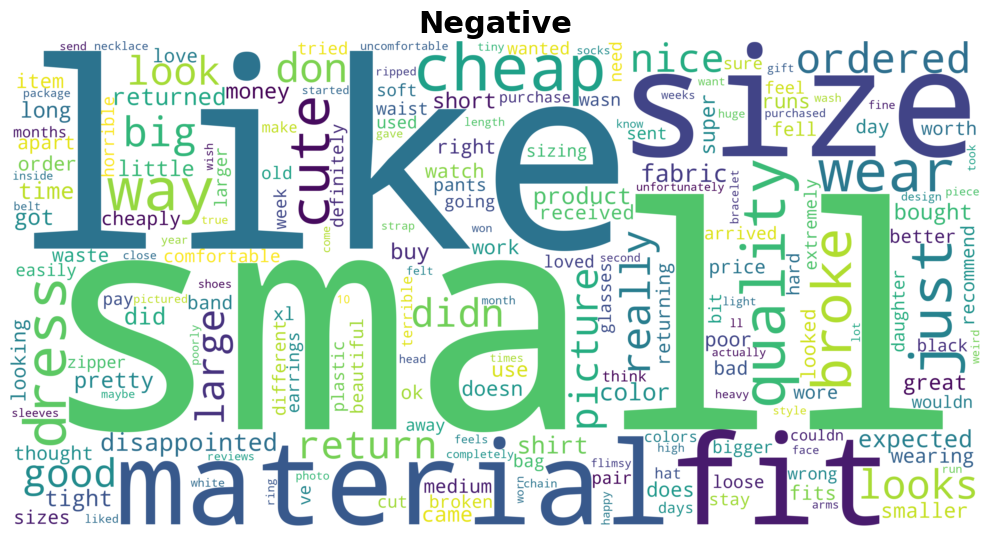

In [12]:
# Function to generate a word cloud for a specific sentiment
def generate_wordcloud_for_sentiment(df, column, value):
    # Filter the DataFrame for the selected sentiment
    sentiment_data = df[df[column] == value]
    
    # Combine all reviews in the filtered DataFrame into one text block
    documents = sentiment_data['text']
    
    # Create TF-IDF vectorizer
    vectorizer = TfidfVectorizer(stop_words='english', lowercase=True)
    
    # Fit and transform the reviews
    tfidf_matrix = vectorizer.fit_transform(documents)
    
    # Get the feature names (terms)
    feature_names = vectorizer.get_feature_names_out()
    
    # Sum the TF-IDF scores for each term
    tfidf_scores = tfidf_matrix.sum(axis=0).A1  # .A1 flattens the matrix
    
    # Create a dictionary mapping words to their corresponding TF-IDF scores
    tfidf_dict = dict(zip(feature_names, tfidf_scores))
    
    # Generate the word cloud
    wordcloud = WordCloud(width=4000, height=2000, background_color='white').generate_from_frequencies(tfidf_dict)
    
    # Display and save the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    if column == 'label':
        if value == 1:
            plt.title('Positive', weight='bold', fontsize=22)
        else:
            plt.title('Negative', weight='bold', fontsize=22)
    else:
        plt.title(f'Rating: {value}', weight='bold', fontsize=22)
    plt.axis('off')
    plt.tight_layout()
    if column == 'label':
        if value == 1:
            plt.savefig('Plots/wordcloud_pos.pdf', format='pdf', dpi=1000)
        else:
            plt.savefig('Plots/wordcloud_neg.pdf', format='pdf', dpi=1000)
    else:
        plt.savefig(f'Plots/wordcloud_rating{value}.pdf', format='pdf', dpi=1000)
    plt.show()

# Generate word clouds for positive and negative sentiments
generate_wordcloud_for_sentiment(reviews_sample, 'label', 1) # positive
generate_wordcloud_for_sentiment(reviews_sample, 'label', 0) # negative

### Word Clouds by Rating

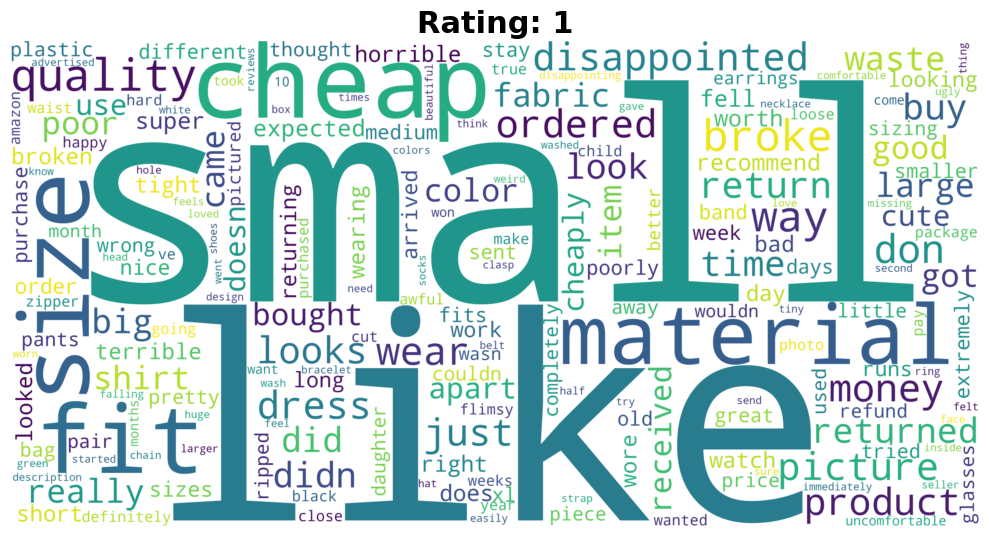

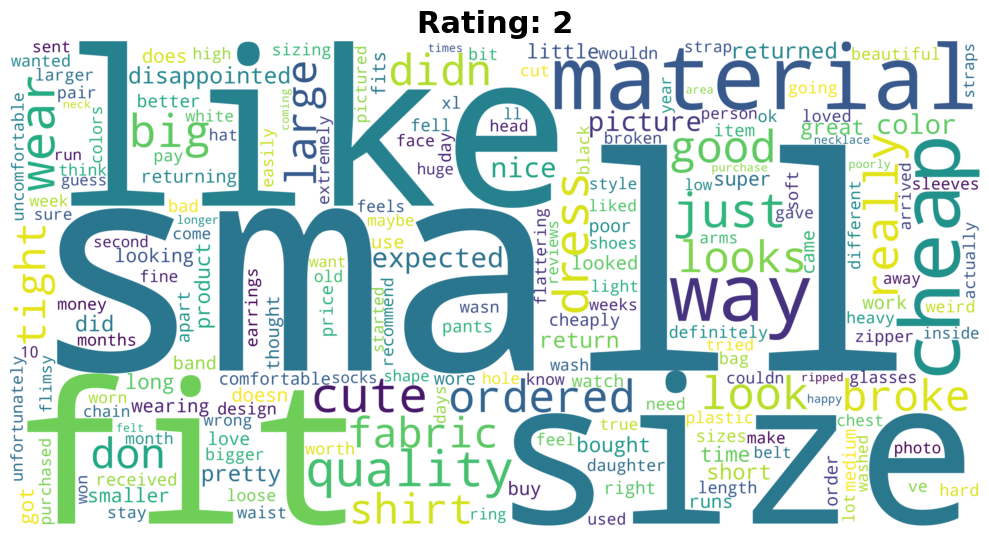

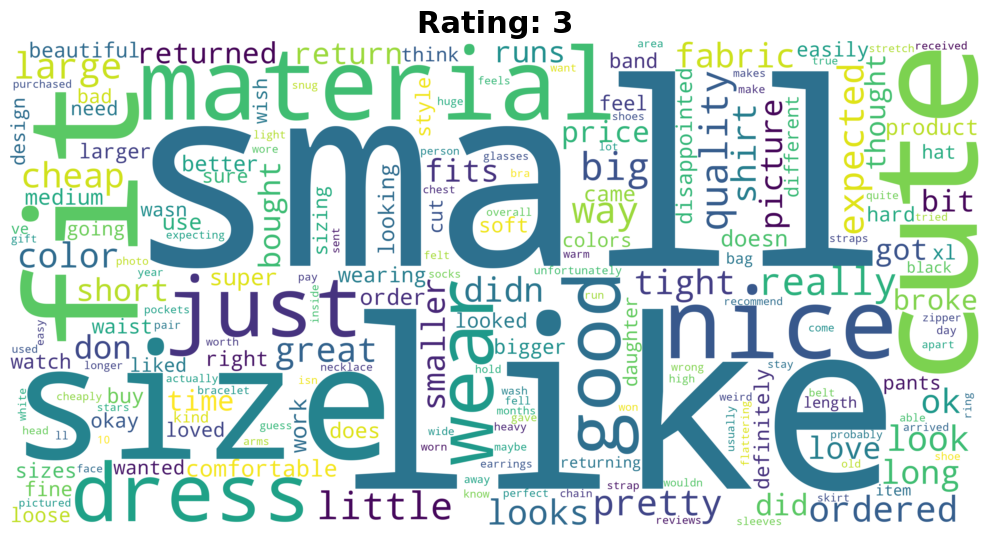

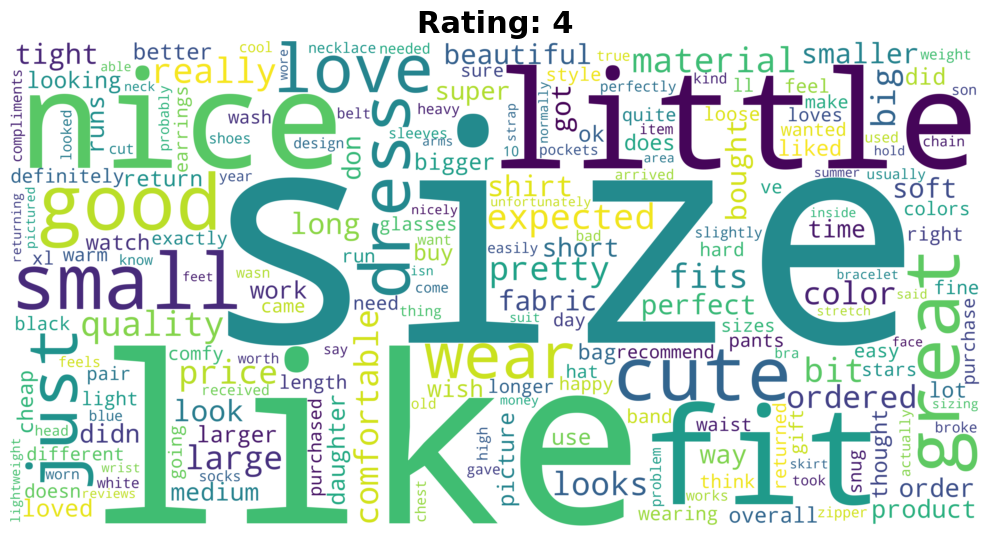

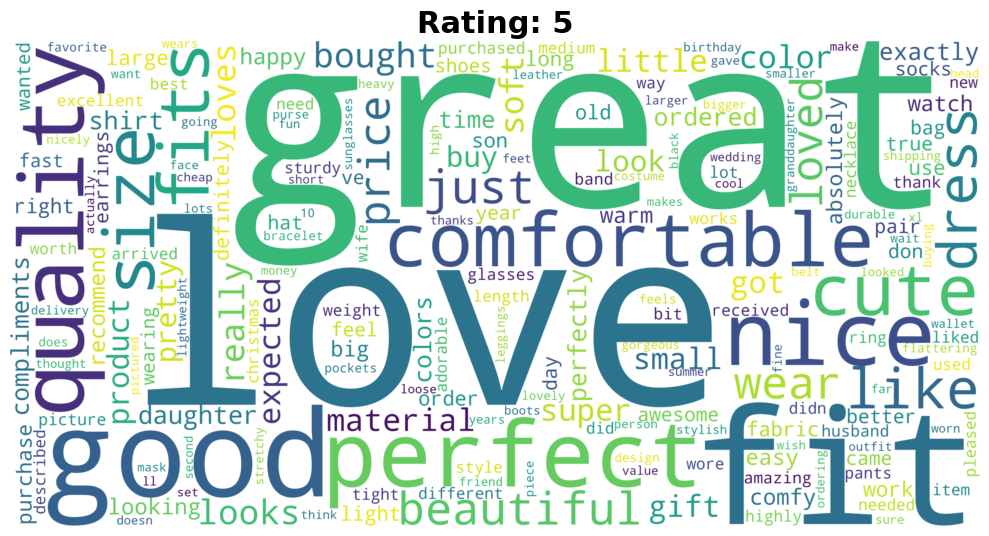

In [13]:
# Generate word clouds for all ratings
generate_wordcloud_for_sentiment(reviews_sample, 'rating', 1)
generate_wordcloud_for_sentiment(reviews_sample, 'rating', 2)
generate_wordcloud_for_sentiment(reviews_sample, 'rating', 3)
generate_wordcloud_for_sentiment(reviews_sample, 'rating', 4)
generate_wordcloud_for_sentiment(reviews_sample, 'rating', 5)

## Topic Modeling using BERTopic

--> see the Notebook [topic_modeling.ipynb](https://github.com/valentin-velev29/DLSS-24-GPT-2-Project) for topic modeling

In [14]:
# Load and print the results of the topic modeling
text_topics = pd.read_csv("Data/topic_modeling_results.csv")
display(text_topics)

Topic  Count                                 Name  \
0       0  63886                0_size_fit_like_small   
1       1  21696            1_quality_broke_one_cheap   
2       2   3919     2_glasses_sunglasses_lenses_pair   
3       3   3078           3_color_colors_green_white   
4       4   1062            4_one_star_stars_received   
5       5   1436            5_support_arch_shoes_feet   
6       6   1123        6_expected_exactly_ok_perfect   
7       7    468     7_umbrella_water_rain_waterproof   
8       8   1505           8_product_watch_work_works   
9       9   1048           9_warm_cold_winter_weather   
10     10    287               10_pay_money_get_waste   
11     11    179  11_instructions_directions_easy_use   
12     12     98          12_football_draft_game_love   
13     13    215      13_bottle_product_water_bottles   

                                       Representation  \
0   ['size', 'fit', 'like', 'small', 'dress', 'wea...   
1   ['quality', 'broke', 'one', 'cheap', 'like', '...   
2   ['glasses', 'sunglasses', 'lenses', 'pair', 'l...   
3   ['color', 'colors', 'green', 'white', 'red', '...   
4   ['one', 'star', 'stars', 'received', 'pair', '...   
5   ['support', 'arch', 'shoes', 'feet', 'frame', ...   
6   ['expected', 'exactly', 'ok', 'perfect', 'desc...   
7   ['umbrella', 'water', 'rain', 'waterproof', 'w...   
8   ['product', 'watch', 'work', 'works', 'use', '...   
9   ['warm', 'cold', 'winter', 'weather', 'hot', '...   
10  ['pay', 'money', 'get', 'waste', 'buy', 'cheap...   
11  ['instructions', 'directions', 'easy', 'use', ...   
12  ['football', 'draft', 'game', 'love', 'nfl', '...   
13  ['bottle', 'product', 'water', 'bottles', 'bag...   

                                  Representative_Docs  
0   ["I ordered this for my 11 year old daughter. ...  
1   ['If you are looking for something to wear now...  
2   ["This case is slightly smaller than the glass...  
3   ['Purchased this for an upcoming fall wedding....  
4   ['Literally just received the package and I’m ...  
5   ['I, a women, bought these to replace some ver...  
6   ['Perfect, exactly what i expected', 'Exactly ...  
7   ["Starting my second season with this umbrella...  
8   ['I have extremely low blood pressure and beca...  
9   ['This is what you need to stay warm if you ar...  
10  ['you get what you pay for.', 'But you get wha...  
11  ["There are NO instructions. After completely ...  
12  ['Dallas fan know win or lose. Dallas all the ...  
13  ["This bottle is SMALL, I have never had this ...